In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from json import load
import re
import numpy as np
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec

In [ ]:
# --- Helpers ---
def add_panel_letter(fig, ax, letter, pad_y=0.008):
    bb = ax.get_position()
    fig.text(bb.x0, bb.y1 + pad_y, letter,
             fontsize=16, fontweight='bold', ha='left', va='bottom',
             path_effects=[pe.withStroke(linewidth=3, foreground='white')])
    
def salinity_from_label(label: str) -> float:
    if 'Control' in label:
        return 34.0
    m = re.search(r'(\d+[.,]?\d*)', str(label))
    return float(m.group(1).replace(',', '.')) if m else np.nan

### Data mortality

In [23]:
data_mortality = pd.read_csv("../data_for_plots/mortality/mortality_curve.csv")

### Data Final bioassay

In [24]:
summary = pd.read_csv("../data_for_plots/mortality/final_bioassay_data.csv")

### Data LC50

In [25]:
df_data = pd.read_csv("../data_for_plots/data_lc50/data_lc50.csv")
df_curve = pd.read_csv("../data_for_plots/data_lc50/df_curve_lc50.csv")

with open("../data_for_plots/data_lc50/data_config.json", 'r') as doc:
    data_lc50 = load(doc)

### Configs

In [27]:
ORDERED_LABELS = ["Control (34.0 g/L)", "36.4 g/L", "45.8 g/L", "51.8 g/L", "57.7 g/L"]
personalized_pallete = ["#bee9e8", "#62b6cb", "#1b4965", "#cae9ff", "#5fa8d3"]  # in same order

LETTERS_DEFAULT = ["a", "a", "ab", "bc", "c"]

### Prepare data for panels

In [31]:
summary = summary[summary['Treatment'].isin(ORDERED_LABELS)].copy()
summary['Treatment'] = pd.Categorical(summary['Treatment'], categories=ORDERED_LABELS, ordered=True)
summary = summary.sort_values('Treatment')
summary['Salinity_gL'] = summary['Treatment'].apply(salinity_from_label)

# Letters
if 'Letters' in summary.columns:
    letters = summary['Letters'].astype(str).tolist()
else:
    letters = LETTERS_DEFAULT[:len(summary)]

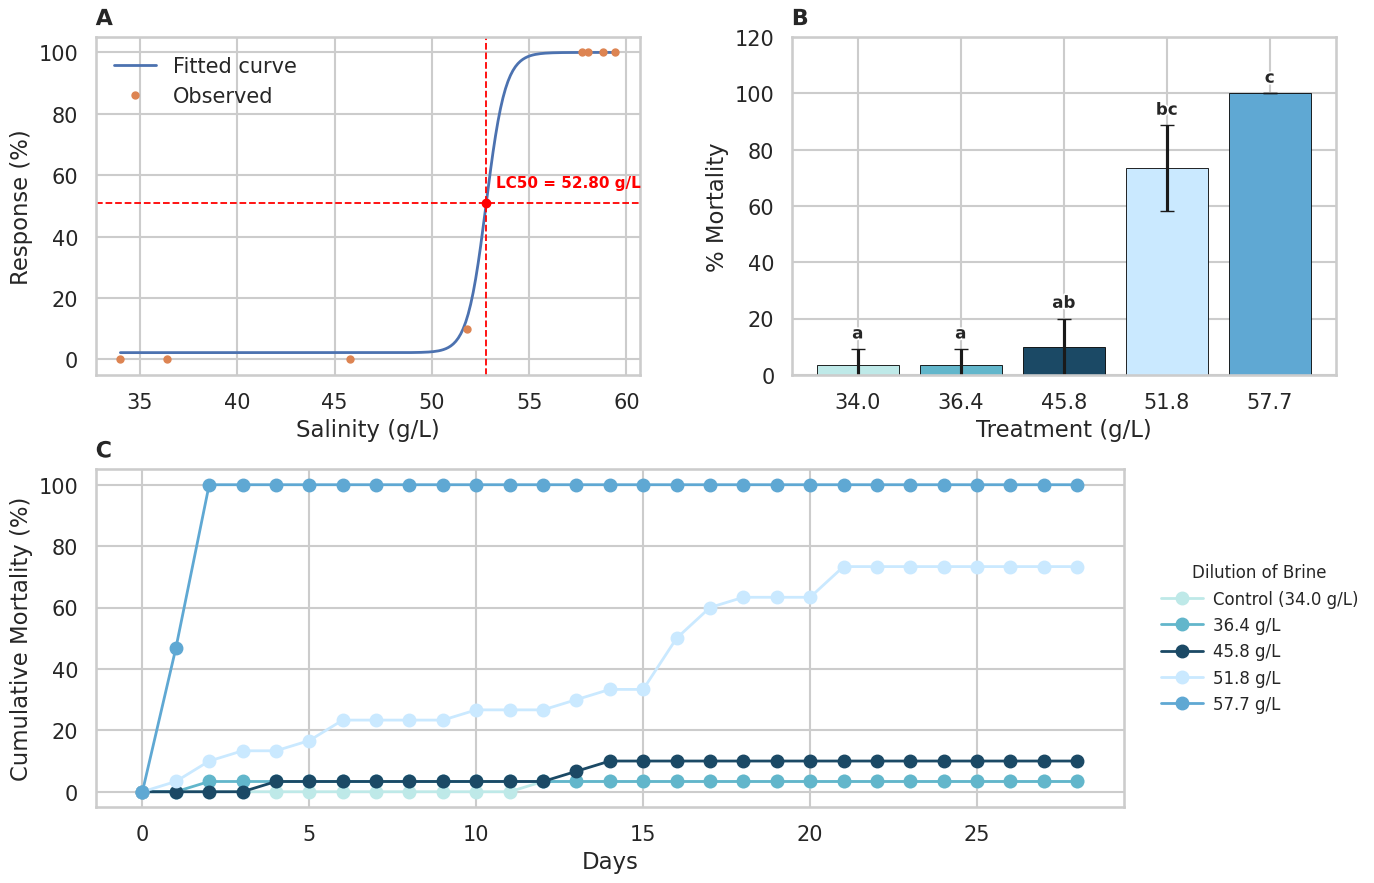

In [54]:
# --- Build multipanel figure (no fitting; uses your files) ---
fig = plt.figure(figsize=(16, 10), constrained_layout=False)

gs = GridSpec(nrows=2, ncols=2, figure=fig, wspace=0.28, hspace=0.28)
axA = fig.add_subplot(gs[0, 0])     
axB = fig.add_subplot(gs[0, 1])     

bottom = gs[1, :].subgridspec(1, 2, width_ratios=[1.70, 0.30], wspace=0.05)
axC   = fig.add_subplot(bottom[0, 0])   
axLeg = fig.add_subplot(bottom[0, 1])   
axLeg.axis("off")  

axA.plot(df_curve.iloc[:,0], df_curve.iloc[:,1], '-', lw=2, label='Fitted curve')
axA.plot(df_data.iloc[:,0], df_data.iloc[:,1], 'o', ms=5, label='Observed')

# LC50 guides
LC50 = data_lc50["LC50"]
LC50_response = data_lc50["LC50_response"]
axA.axvline(LC50, ls='--', color='red', lw=1.3)
axA.axhline(LC50_response, ls='--', color='red', lw=1.3)
axA.plot([LC50],[LC50_response], 'o', color='red', ms=6)
axA.text(LC50 + 0.5, LC50_response + 5, f'LC50 = {LC50:.2f} g/L',
            color='red', fontsize=11, weight='bold')
axA.set_xlabel('Salinity (g/L)')
axA.set_ylabel('Response (%)')
axA.legend(frameon=False)

add_panel_letter(fig, axA, "A")

x = np.arange(len(summary))
means = summary['Mean % Mortality'].to_numpy(float)
sds   = summary['SD % Mortality'].to_numpy(float)
color_map = {lab: col for lab, col in zip(ORDERED_LABELS, personalized_pallete)}
colors = [color_map.get(lab, '#999999') for lab in summary['Treatment']]

bars = axB.bar(x, means, yerr=sds, capsize=5, edgecolor='black', linewidth=0.6, color=colors)
axB.set_xticks(x, [f"{s:.1f}" for s in summary['Salinity_gL']])
axB.set_xlabel('Treatment (g/L)')
axB.set_ylabel('% Mortality')

ymax = max(100.0, np.nanmax(means + np.nan_to_num(sds)) * 1.20)
axB.set_ylim(0, ymax)
for xi, (m, sd, txt) in enumerate(zip(means, sds, letters)):
    ytxt = (m + (sd if not np.isnan(sd) else 0.0)) + 0.02*ymax
    axB.text(xi, ytxt, txt, ha='center', va='bottom', fontsize=12, fontweight='bold',
             path_effects=[pe.withStroke(linewidth=2.5, foreground='white')])
add_panel_letter(fig, axB, "B")

days_col = next((c for c in data_mortality.columns if c.lower().strip() in ['days','day']), None)
mort_col = next((c for c in data_mortality.columns if 'mort' in c.lower()), None)
hue_col  = next((c for c in data_mortality.columns if any(k in c.lower() for k in ['dilution','treat','brine'])), None)
for lab, col in zip(ORDERED_LABELS, personalized_pallete):
    # try matching by salinity number contained in label (e.g., "36.4")
    key = '34.0' if 'Control' in lab else lab.split()[0]
    mask = data_mortality[hue_col].astype(str).str.contains(key, regex=False)
    if mask.any():
        sub = data_mortality[mask].sort_values(days_col)
        axC.plot(sub[days_col], sub[mort_col], marker='o', lw=2, label=lab, color=col)

axC.set_xlabel('Days')
axC.set_ylabel('Cumulative Mortality (%)')

legC = axC.get_legend()
if legC is not None:
    legC.remove()

handles, labels = axC.get_legend_handles_labels()
if not labels:
    lines = [ln for ln in axC.get_lines() if ln.get_label() != "_nolegend_"]
    handles = lines
    labels  = [ln.get_label() for ln in lines]

axLeg.legend(handles, labels,
             title="Dilution of Brine", frameon=False,
             loc="center left", fontsize=12, title_fontsize=12,
             handlelength=2.5, handletextpad=0.6, borderaxespad=0.0)

add_panel_letter(fig, axC, "C")

fig.savefig("../figures_paper/figure_02.png", dpi=300, bbox_inches='tight')
